# Imports

In [4]:
import random
import datajoint as dj
#from phase3 import nda, func, utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image
from matplotlib import cm
from collections import defaultdict
from scipy.optimize import curve_fit
import time
import gc
from PIL import Image
import warnings
import pickle
#!pip3 install scikit-learn
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import r2_score
from scipy.stats import sem
from scipy.stats import mannwhitneyu, wilcoxon
import os

# Utility function

In [ ]:
def orientation_extractor(unit_key, fpd):
    ''' This function allows to extract the mean activity corresponding to each repeat
    of the direction shown as part of the Monet2 stimuli for a specified neuron

    Parameters:
    unit_key: dictionary specifying the value for the session, scan_idx and unit_idx keys
    fpd: frames per direction of the movie shown (might change in different session, scan_idx pairs)
    
    Returns:
    df: DataFrame with a columnd showing the directions inn degrees, teh directionns in radians and the
    mean activity of that cell across all the Monet2 trial that had that direction
    '''
    
    #Select the movie trials in the appropiate session and scan
    trial_key = {'session': unit_key['session'], 'scan_idx': unit_key['scan_idx']}
    trial_info = nda.Trial & trial_key
    
    #Extract the direction variables for the Monet2 stimuli in these trials
    dirs = (trial_info* nda.Monet2).fetch('directions')
    spike_trace = (nda.Activity() & unit_key).fetch1('trace')

    #Extract start and end frames
    s = (trial_info * nda.Monet2).fetch('start_idx')
    e = (trial_info * nda.Monet2).fetch('end_idx')
    
    #Loop thorugh them and calculate average activity and corresponding direction
    directions=[]
    m_act = []
    trial_id = []
    d = 0

    #loop though each monet trial
    for seg in range(len(s)):
        st = s[seg]
        en = e[seg]
        c = 0

        #extract the relevant spike trace segment
        sp_red = spike_trace[st:en+1]
        #loop though each six frames with same orientation
        if fpd>6: #change number of frame that have the same direction since session 9 had a higher frame rate of 8
            for i in range(0, sp_red.shape[0], fpd):
                if c < 16:
                    directions.append(dirs[d][0][c]) #d: monet trial number, 0: selects array, c: orientation index
                    m_act.append(np.mean(sp_red[i:i+fpd]))
                else:
                    continue
                    #directions.append(dirs[d][0][c])
                    #m_act.append(np.mean(sp_red[i:]))
                c+=1
                trial_id.append(d)
        else:    
            for i in range(0, sp_red.shape[0], 6):
                if c < 16:
                    directions.append(dirs[d][0][c]) #d: monet trial number, 0: selects array, c: orientation index
                    m_act.append(np.mean(sp_red[i:i+6]))
                else:
                    directions.append(dirs[d][0][c])
                    m_act.append(np.mean(sp_red[i:]))
                c+=1
                trial_id.append(d)
        d+=1
    #Save them in a data frame  
    df = pd.DataFrame({'orientation':directions, 'mean_activity':m_act, 'trial_id':trial_id})
    
    #Turn orientation in to radians
    df['radians'] = df['orientation']*(np.pi/180)
    
    return df

In [ ]:
def von_mises(theta, A, phi, k):
    '''Function describing the tuning curve of the neurone to the orientation of the stimulus if the neurone is ONLY
    orientation selective
    
    Parameters:
    theta: orientation of the stimulus
    A: amplitude of the cosine wave
    phi: offset of the wave
    rmax: maximum value the activation can take (max value of sigmoid function)
    L0: inflection point of the sigmoid
    
    Returns:
    activity of neuron at specified angle'''
    
    r = A*np.exp(k*(np.cos(2*(theta-phi))-1))
    
    return r

In [ ]:
def von_mises_single(theta, A, phi, k):
    ''' Function describing the tuning curve of the neurone to the orientation of the stimulus if the neuron
    is both orientation and direction selective
    
    Parameters:
    theta: orientation of the stimulus
    A: amplitude of the cosine wave
    phi: offset of the wave
    rmax: maximum value the activation can take (max value of sigmoid function)
    L0: inflection point of the sigmoid
    
    Returns:
    activity of neuron at specified angle'''
    
    r = A*np.exp(k*(np.cos((theta-phi))-1))
    
    return r

In [ ]:
def is_selective(df, max_rad, single = True):
    '''This function utilises a wilcoxon test to understand if there is a significant difference
    between the activity of a neuron at its estimated preferred orientation and its estimated least preferred
    orientation so as to understand if its oreintation and direction selective or just orientation
    
    Parameters:
    df: DataFrame with directions and mean activity at each direction
    max_rad: integer or float with estimated preferred orientation of the cell
    single: boolean idenfiying whether we are testing for oreintationn selectivity (single = True)
    or orientation and direction selectivity (single = False)
    
    Returns:
    statw: wilcoxon statistics value
    pw: p value of the wilcoxon test
    min_rad: estimated least preferred orientation
    '''
    #If there is a single peak, frequency of 2pi
    if single:
        if max_rad>np.pi:
            min_rad = max_rad-np.pi
        else:
            min_rad = max_rad+np.pi
    
    #If there are two peak, frequency of pi
    else:
        if max_rad>(np.pi*1.5):
            min_rad = max_rad-(np.pi/2)
        else:
            min_rad = max_rad+(np.pi/2)
        
    
    closemax= df.iloc[(df['radians']-max_rad).abs().argsort()[:1]].iloc[0,3]
    closemin = df.iloc[(df['radians']-min_rad).abs().argsort()[:1]].iloc[0,3]
    max_act = df[df['radians'] == closemax]['mean_activity']
    min_act = df[df['radians'] == closemin]['mean_activity']
    statw, pw = wilcoxon(max_act, min_act)
    
    return statw, pw, min_rad

In [ ]:
for pair in [(4, 7)]:
    
    #Containers with saved data
    data = []
        
    #Von Mises
    columns = ['session', 'scan_idx','cell_id', 'pvalue','model_type', 
    'r_squared_diff', 'mean_r_sqrd', 'A', 'phi', 'k']

    #Subset the cells for server limitation reasons
    sub = func_ccmax[(func_ccmax['session'] == pair[0]) & (func_ccmax['scan_idx'] == pair[1])]
    
    #loop through cells
    for i in tqdm(range(sub.shape[0]), desc = 'cell loop' ):
        unit_key = {'session':pair[0], 'scan_idx':pair[1], 'unit_id':sub.iloc[i,6]}
        df = orientation_extractor(unit_key, 6)

        #Using Von Mises
        pars_d, pcov_d = curve_fit(von_mises, df['radians'], df['mean_activity'],
                               bounds = ([-np.inf, 0, 0],[np.inf, 2*np.pi, np.inf]),
                               method = 'trf', max_nfev = df.shape[0]*1000)

        pars_s, pcov_s = curve_fit(von_mises_single, df['radians'], df['mean_activity'], 
                               bounds = ([-np.inf, 0, 0],[np.inf, 2*np.pi, np.inf]),
                               method = 'trf', max_nfev = df.shape[0]*1000)

        #Calculating standard errors, for plotting data and fit
        gp = df.groupby('radians').mean().reset_index()

        # Von Mises activities
        ate_d= [von_mises(i,pars_d[0], pars_d[1], pars_d[2]) for i in gp['radians']]
        ate_s= [von_mises_single(i,pars_s[0],  pars_s[1], pars_s[2]) for i in gp['radians']]
        
        r2d = r2_score(gp['mean_activity'], ate_d)
        r2s = r2_score(gp['mean_activity'], ate_s)

        #Calculate difference in r2 score between the two model fist to identify fringe cases
        rdiff = r2d-r2s
        
        #single
        vs, ps, max_rad = is_selective(df, pars_s[1])


        #double
        vdb, pdb, max_rad = is_selective(df, pars_d[1], single = False)
        
        
        #save data
        data.append([pair[0], pair[1], unit_key['unit_id'],ps,'single', rdiff, r2s]+list(pars_s))
        
        #save data
        data.append([pair[0], pair[1], unit_key['unit_id'],pdb,'double', rdiff,r2d]+list(pars_d))
        
    #Save the data
    data_df = pd.DataFrame(data, columns = columns)
    data_df.to_csv(f'orientations_fits_{pair[0]}_{pair[1]}.csv', index = False)
    
    #Clean RAM
    del sub, unit_key, df, gp, pars_s, pars_d, pcov_s, pcov_d, ate_d, ate_s, r2d, r2s, rdiff, vs, ps, vdb, pdb, max_rad
    gc.collect()    

# Selectivity

In [99]:
selective_cells = pd.read_pickle('/home/jacopobigg/Desktop/MICrONS_modelling/selective_cells.pkl')
sample6_4 = pd.read_pickle('/home/jacopobigg/Desktop/MICrONS_modelling/neurons_64.pkl')
selective_cells['idx_large'] = [i for i in range(len(selective_cells))]
sample6_4['idx_64'] = [int(i) for i in range(len(sample6_4))]

sample_merged = sample6_4.merge(selective_cells, on = ['session', 'scan_idx', 'unit_id'], how = 'inner')
sample_merged = sample_merged.sort_values(by= 'unit_id')
sample_merged.shape

orientations_order = pd.read_pickle('orientation_onsets.pkl').sort_values(['hash', 'start_idx'])
orientations_order['hash']= orientations_order['hash'].replace('yv/S61fYnDSQcA9J6Nk8', 'S61fYnDSQcA9J6Nk8')
orientations_order['hash']= orientations_order['hash'].replace('AZvr1UF39ygFqNxKr/8K', 'AZvr1UF39ygFqNxKr')
orientations_order['ori_extended'] = [np.repeat(i, 6)[:-3] for i in orientations_order['directions']]

In [59]:
arsp = []
hash_order = []

for h in tqdm(os.listdir('/home/jacopobigg/Desktop/MICrONS_modelling/monet_preds')):
    if (h != '.DS_Store'):
        act_temp = np.load(f'/home/jacopobigg/Desktop/MICrONS_modelling/monet_preds/{h}/monet_pred.npy')
        ors_t= np.hstack(orientations_order[orientations_order['hash'] == h]['ori_extended'].values)
        act_temp = np.hstack([act_temp, ors_t.reshape(186,1)])


        arsp.append(act_temp)
        hash_order.append(h)

actori_preds = np.vstack(arsp)

100%|██████████| 20/20 [00:00<00:00, 566.97it/s]


In [69]:
df_preds = pd.DataFrame(actori_preds, columns = [f'n_{i}' for i in range(836)]+['ori'])
df_preds['radians'] = df_preds['ori']*(np.pi/180)
preds_group = df_preds.groupby('radians').mean().reset_index()
preds_group

,radians,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,...,n_827,n_828,n_829,n_830,n_831,n_832,n_833,n_834,n_835,ori
0,0.000000,-0.006972,0.009303,-0.022730,-0.060889,0.024713,0.010012,-0.008611,-0.004407,-0.021732,...,-0.005504,0.000079,-0.014554,0.003983,-0.000626,0.107866,0.000485,0.043861,-0.081542,0.0
1,0.392699,-0.008763,0.010002,-0.026803,-0.076789,0.029375,0.011960,-0.011085,-0.004687,-0.022143,...,-0.007936,-0.000165,-0.016829,0.003652,-0.000789,0.125660,0.001333,0.051671,-0.104301,22.5
2,0.785398,-0.008586,0.010779,-0.030628,-0.080600,0.027559,0.010908,-0.014357,-0.005142,-0.027653,...,-0.008936,-0.000003,-0.016908,0.003902,0.000273,0.136871,-0.000324,0.058792,-0.068812,45.0
3,1.178097,-0.008957,0.010470,-0.030381,-0.080749,0.029791,0.012855,-0.013171,-0.004862,-0.025711,...,-0.009043,-0.000160,-0.016805,0.003631,-0.000250,0.137138,-0.000343,0.056171,-0.050413,67.5
4,1.570796,-0.010024,0.011737,-0.027941,-0.079205,0.024614,0.010957,-0.013130,-0.005240,-0.031178,...,-0.010928,-0.000015,-0.017491,0.003740,0.000090,0.129911,0.000022,0.053851,-0.025378,90.0
5,1.963495,-0.009134,0.010087,-0.025403,-0.069153,0.019977,0.010864,-0.010381,-0.005634,-0.033032,...,-0.010678,-0.000070,-0.015798,0.002841,-0.000260,0.116889,-0.000909,0.052474,0.008072,112.5
6,2.356194,-0.008751,0.009710,-0.024016,-0.061602,0.019036,0.009952,-0.009088,-0.005034,-0.030050,...,-0.007766,0.000182,-0.013509,0.003504,0.001204,0.106849,-0.000724,0.046008,-0.036295,135.0
7,2.748894,-0.006695,0.009192,-0.020856,-0.060515,0.018510,0.009437,-0.004688,-0.004864,-0.023986,...,-0.006017,0.000133,-0.014232,0.003073,-0.000470,0.101048,0.000116,0.045774,-0.056899,157.5
8,3.141593,-0.008173,0.010122,-0.023035,-0.062663,0.022870,0.009308,-0.009316,-0.005426,-0.020633,...,-0.007334,0.000154,-0.014635,0.003681,0.002546,0.111674,0.000498,0.045473,-0.077739,180.0
9,3.534292,-0.007661,0.009263,-0.027556,-0.074953,0.025805,0.011113,-0.012249,-0.004687,-0.026825,...,-0.005860,0.000210,-0.016113,0.004079,-0.001684,0.123894,0.000356,0.048503,-0.094746,202.5


In [64]:
arsr = []

for h in tqdm(hash_order):
    act_temp = np.load(f'/home/jacopobigg/Desktop/MICrONS_modelling/monet/{h}/monet_spike_836.npy')
    ors_t= np.hstack(orientations_order[orientations_order['hash'] == h]['ori_extended'].values)
    act_temp = np.hstack([act_temp, ors_t.reshape(186,1)])


    arsr.append(act_temp)

actori_real = np.vstack(arsr)

100%|██████████| 20/20 [00:00<00:00, 379.72it/s]


In [65]:
df_real = pd.DataFrame(actori_real, columns = [f'n_{i}' for i in range(836)]+['ori'])
df_real['radians'] = df_real['ori']*(np.pi/180)
real_groups = df_real.groupby('radians').mean().reset_index()

In [103]:
sample_merged['idx_64'].head(10)

0     5
1     8
2    11
3    15
4    19
5    22
6    23
7    27
8    28
9    29
Name: idx_64, dtype: int64

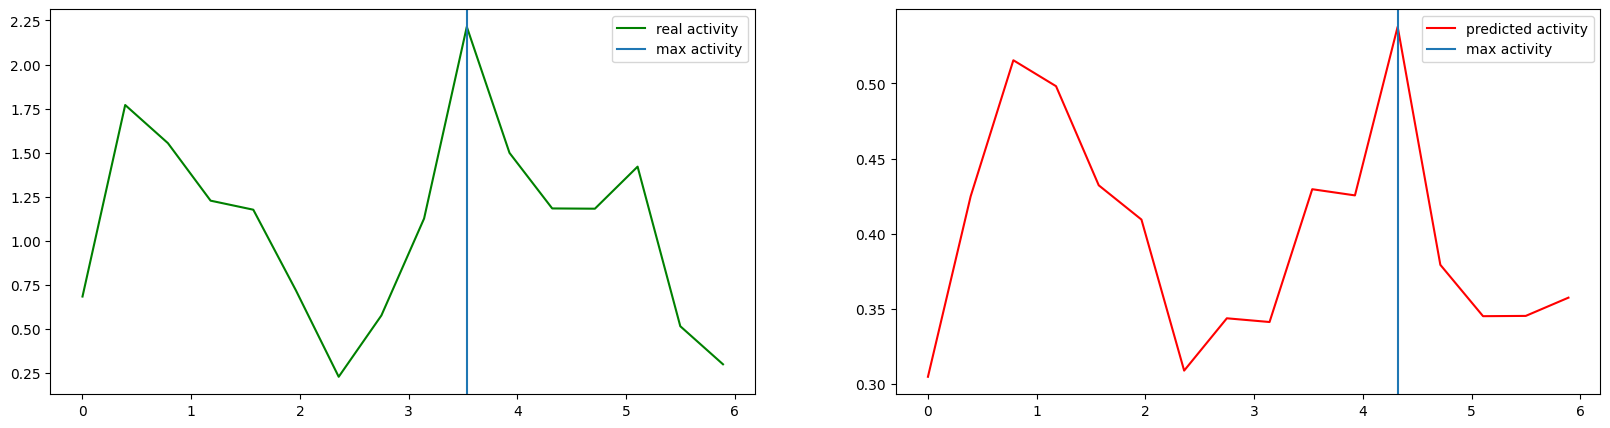

In [105]:
n_id = 28
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

real_max = real_groups.iloc[:, 0].values[np.argmax(real_groups.iloc[:, n_id])]
pred_max = preds_group.iloc[:, 0].values[np.argmax(preds_group.iloc[:, n_id])]

ax[0].plot(real_groups['radians'], real_groups.iloc[:, n_id], color = 'green', label = 'real activity')
ax[0].axvline(real_max, label = 'max activity')
ax[0].legend()

ax[1].plot(preds_group['radians'], preds_group.iloc[:, n_id], color = 'red', label = 'predicted activity')
ax[1].axvline(pred_max, label = 'max activity')
ax[1].legend()

plt.show()

In [74]:
pref_oripreds = [preds_group.iloc[:, 0].values[np.argmax(preds_group.iloc[:, i])]  for i in range(1, 837)]
pref_orireal= [real_groups.iloc[:, 0].values[np.argmax(real_groups.iloc[:, i])]  for i in range(1, 837)]

Text(0.5, 0, 'preds')

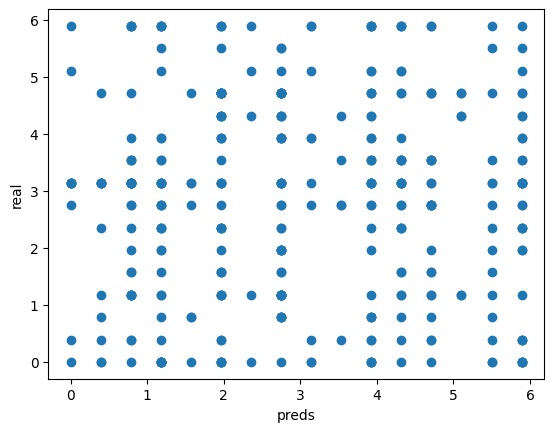

In [101]:
plt.scatter(np.array(pref_oripreds)[sample_merged['idx_64'].values], np.array(pref_orireal)[sample_merged['idx_64'].values])
plt.ylabel('real')
plt.xlabel('preds')

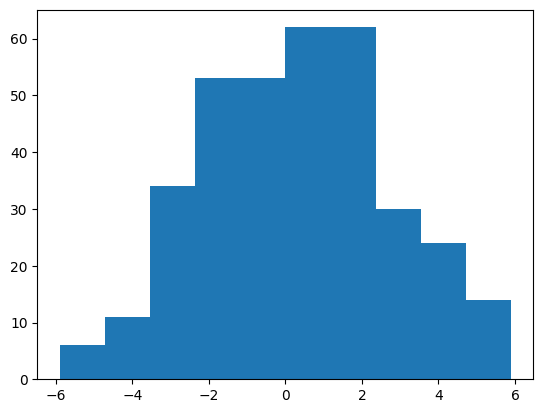

In [102]:
plt.hist(np.array(pref_oripreds)[sample_merged['idx_64'].values]-np.array(pref_orireal)[sample_merged['idx_64'].values])
plt.show()

# Vector similarity analisis

In [125]:
connectome = pd.read_csv('/home/jacopobigg/Desktop/MICrONS_modelling/functional_connectome_stcorr.csv')
func_cells = pd.read_pickle('/home/jacopobigg/Desktop/MICrONS_modelling/clean_functional_layers.pkl')
sample6_4 = pd.read_pickle('/home/jacopobigg/Desktop/MICrONS_modelling/neurons_64.pkl')
func_cells['idx_large'] = [i for i in range(len(func_cells))]
sample6_4['idx_64'] = [int(i) for i in range(len(sample6_4))]
feature_weights = np.load('/home/jacopobigg/Desktop/MICrONS_modelling/feature_vectors.npy')
sample6_4['feat_w']= [ i for i in feature_weights]

sample_merged = sample6_4.merge(func_cells, on = ['session', 'scan_idx', 'unit_id'], how = 'inner')
sample_merged = sample_merged.sort_values(by= 'unit_id')
sample_merged=sample_merged.loc[:, ['session', 'scan_idx', 'unit_id', 'pt_root_id', 'cortex_layer', 'feat_w']]


In [126]:
connectome.head()

,post_pt_root_id,pre_pt_root_id,size,post_pt_position,pre_pt_position,stcorr_1,stcorr_2,stcorr_3,stcorr_4,stcorr_5,stcorr_6,stcorr_7,stcorr_8,stcorr_9,stcorr_10,stcorr_mean
0,864691135181717506,864691136443721859,1496,[261630 189848 24674],[261640 189828 24664],0.103711,-0.032221,0.079145,-0.025232,0.086377,0.142175,-0.032064,0.077688,0.040854,0.006311,0.086219
1,864691135181717506,864691136443721859,7728,[261900 189750 24647],[261792 189752 24646],0.103711,-0.032221,0.079145,-0.025232,0.086377,0.142175,-0.032064,0.077688,0.040854,0.006311,0.086219
2,864691135181717506,864691136443721859,29244,[261206 190324 24603],[261286 190254 24613],0.103711,-0.032221,0.079145,-0.025232,0.086377,0.142175,-0.032064,0.077688,0.040854,0.006311,0.086219
3,864691135181717506,864691136443721859,9096,[261382 192702 24706],[261444 192708 24722],0.103711,-0.032221,0.079145,-0.025232,0.086377,0.142175,-0.032064,0.077688,0.040854,0.006311,0.086219
4,864691135181717506,864691136023738425,3204,[233898 180088 26728],[234010 180110 26718],0.051529,0.069362,-0.013272,0.005766,-0.039645,-0.010331,-0.003274,0.012647,-0.019764,0.006723,-0.009099


In [128]:
sample_merged.to_pickle('neurons64features.pkl')